## Final Project Submission

* Student name: Qilun Chen, Evan Serrano
* Student pace: full time
* Scheduled project review date/time: April/1/2022
* Instructor name: Praveen Gowtham, Joe Comeaux
* Blog post URL:https://github.com/nkbuddy/dsc-phase-2-project-NYC


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

%matplotlib inline

# Data cleaning

In [28]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [29]:
data.isna()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21593,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21594,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21595,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

change sqft_basement from object to float

In [6]:
data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")
data.loc[:, 'sqft_basement'] = data['sqft_basement'].astype('float64')

/var/folders/8y/cslj48jd39z6f0kr2m9qqjy00000gn/T/ipykernel_75418/327206397.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data.loc[:, 'sqft_basement'] = data['sqft_basement'].str.replace("?","0.0")


replace NaN in view to NONE

In [7]:
data['view'] = data['view'].fillna('NONE')

replace NaN in waterfront to NO



In [8]:
data['waterfront'] = data['waterfront'].fillna('NO')

replace NaN in yr_renovated to 0

In [9]:
data['yr_renovated'] = data['yr_renovated'].fillna(0)

check how many NaN in data



In [10]:
data.isna().sum().sum()

0

drop lat column and long column in data

In [11]:
data.drop(columns = 'lat', inplace = True)


In [12]:
data.drop(columns = 'long', inplace = True)

chreate new columns livingAreaRatio, year_sold, houseAge, pricePerSqft

In [13]:
data['livingAreaRatio'] = data['sqft_living'] / data['sqft_lot']

In [14]:
data['date'] = pd.to_datetime(data['date'])
data['year_sold'] = data['date'].dt.year

In [15]:
data['houseAge'] = data['year_sold'] - data['yr_built']

In [16]:
data['pricePerSqft'] = data['price'] / data['sqft_lot']

change columns waterfront, view, condition, grade to Ordinal encoding



In [17]:
data['waterfront'] = pd.get_dummies(data['waterfront'], drop_first = True)

In [18]:
data['view'] = data['view'].astype('category')

In [19]:
data['view'] = data['view'].cat.reorder_categories(['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT'])


In [20]:
data['view'] = data['view'].cat.codes


In [21]:
data['condition'] = data['condition'].astype('category')


In [22]:
data['condition'] = data['condition'].cat.codes


In [23]:
data['grade'] = data['grade'].astype('category')


In [24]:
data['grade'] = data['grade'].cat.codes


# Exploring the Data

Create an initial heatmap

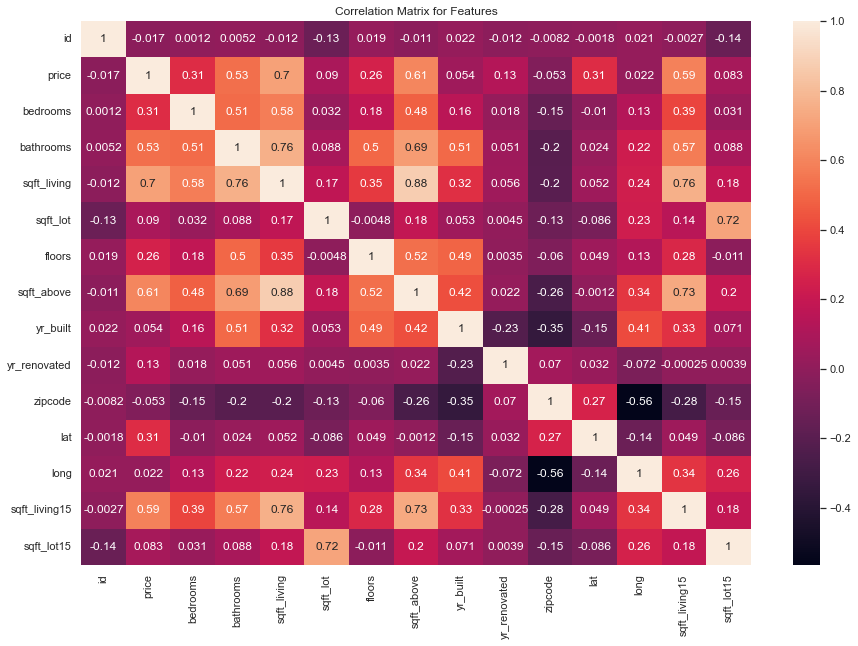

In [48]:
plt.figure(figsize = (15, 10))
sns.set(style="white")
sns.heatmap(data.corr(), annot = True)


plt.title('Correlation Matrix for Features')
plt.savefig("corrmat.jpg" , dpi=300)
plt.show()